<a href="https://colab.research.google.com/github/LEE-SANG-HYUK/Titanic/blob/main/titanic_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

In [68]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")
submit = pd.read_csv("/content/drive/MyDrive/test.csv")

In [69]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [70]:
full_data = [train, submit]

In [71]:
titanic = pd.concat([train, submit], axis=0).reset_index(drop=True)

1.Age

In [72]:
titanic['Age'] = titanic.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

In [73]:
titanic['Age'] = pd.cut(titanic['Age'].astype(int), 5)

In [74]:
titanic['Age'].value_counts()

(16.0, 32.0]     752
(32.0, 48.0]     304
(-0.08, 16.0]    134
(48.0, 64.0]     106
(64.0, 80.0]      13
Name: Age, dtype: int64

2.Fare

In [75]:
titanic.loc[titanic['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,"(48.0, 64.0]",0,0,3701,NaN,NaN,S


In [76]:
Thomas = titanic.loc[(titanic['Pclass'] == 3) & (titanic['SibSp'] == 0) & (titanic['Embarked'] == 'S')]['Fare'].median()
print(Thomas)

7.925


In [77]:
titanic.loc[titanic['Fare'].isnull(), 'Fare'] = Thomas

In [78]:
titanic['Fare'] = pd.qcut(titanic['Fare'], 5)

In [79]:
titanic['Fare'].value_counts()

(-0.001, 7.854]      275
(21.558, 41.579]     265
(41.579, 512.329]    259
(10.5, 21.558]       255
(7.854, 10.5]        255
Name: Fare, dtype: int64

3.Cabin

In [81]:
print(titanic['Cabin'].unique())

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148' 'B45' 'B36' 'A21' 'D34' 'A9' 'C31' 'B61' 'C5

In [82]:
print(titanic['Cabin'].nunique())
print(titanic['Cabin'].isnull().sum())

186
1014


In [83]:
titanic['Deck'] = titanic['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [84]:
titanic[titanic['Pclass']==1]['Deck'].value_counts()

C    94
M    67
B    65
D    40
E    34
A    22
T     1
Name: Deck, dtype: int64

In [85]:
titanic[titanic['Pclass']==2]['Deck'].value_counts()

M    254
F     13
D      6
E      4
Name: Deck, dtype: int64

In [86]:
titanic[titanic['Pclass']==3]['Deck'].value_counts()

M    693
F      8
G      5
E      3
Name: Deck, dtype: int64

In [87]:
titanic[titanic['Deck'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,"(32.0, 48.0]",0,0,113784,"(21.558, 41.579]",T,S,T


In [88]:
idx = titanic[titanic['Deck'] == 'T'].index
titanic.loc[idx, 'Deck'] = 'A'

In [89]:
titanic['Deck'] = titanic['Deck'].replace(['A', 'B', 'C'], 'ABC')
titanic['Deck'] = titanic['Deck'].replace(['D', 'E'], 'DE')
titanic['Deck'] = titanic['Deck'].replace(['F', 'G'], 'FG')

titanic['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [90]:
titanic.loc[(titanic['Pclass']==1) & (titanic['Deck']=='M'), 'Deck'] = 'ABC'
titanic.loc[(titanic['Pclass']==2) & (titanic['Deck']=='M'), 'Deck'] = 'DE'
titanic.loc[(titanic['Pclass']==3) & (titanic['Deck']=='M'), 'Deck'] = 'FG'

familysz

In [91]:
titanic['Family_size'] = titanic['SibSp'] + titanic['Parch'] + 1

In [92]:
titanic['Family_size'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family_size, dtype: int64

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Family_size
0,1,0.0,3,"Braund, Mr. Owen Harris",male,"(16.0, 32.0]",1,0,A/5 21171,"(-0.001, 7.854]",NaN,S,FG,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"(32.0, 48.0]",1,0,PC 17599,"(41.579, 512.329]",C85,C,ABC,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,"(16.0, 32.0]",0,0,STON/O2. 3101282,"(7.854, 10.5]",NaN,S,FG,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"(32.0, 48.0]",1,0,113803,"(41.579, 512.329]",C123,S,ABC,2
4,5,0.0,3,"Allen, Mr. William Henry",male,"(32.0, 48.0]",0,0,373450,"(7.854, 10.5]",NaN,S,FG,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,"(16.0, 32.0]",0,0,A.5. 3236,"(7.854, 10.5]",NaN,S,FG,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,"(32.0, 48.0]",0,0,PC 17758,"(41.579, 512.329]",C105,C,ABC,1
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,"(32.0, 48.0]",0,0,SOTON/O.Q. 3101262,"(-0.001, 7.854]",NaN,S,FG,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,"(16.0, 32.0]",0,0,359309,"(7.854, 10.5]",NaN,S,FG,1


In [95]:
titanic['Sex'] = titanic['Sex'].astype('category')
titanic['Sex'] = titanic['Sex'].cat.codes

In [96]:
titanic['Fare'] = titanic['Fare'].astype('category')
titanic['Fare'] = titanic['Fare'].cat.codes

In [97]:
titanic['Age'] = titanic['Age'].astype('category')
titanic['Age'] = titanic['Age'].cat.codes

In [98]:
titanic['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [99]:
titanic['Embarked'] = titanic['Embarked'].fillna('S')

In [100]:
titanic['Embarked'] = titanic['Embarked'].astype('category')
titanic['Embarked'] = titanic['Embarked'].cat.codes

In [101]:
titanic['Deck'] = titanic['Deck'].astype('category')
titanic['Deck'] = titanic['Deck'].cat.codes

In [102]:
titanic = titanic.drop(['PassengerId', 'Ticket', 'Cabin', 'Name'], axis=1)

In [329]:
train = titanic.loc[:890]
test = titanic.loc[891:].drop(['Survived'], axis=1)

In [330]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Family_size
0,0.0,3,1,1,1,0,0,2,2,2
1,1.0,1,0,2,1,0,4,0,0,2
2,1.0,3,0,1,0,0,1,2,2,1
3,1.0,1,0,2,1,0,4,2,0,2
4,0.0,3,1,2,0,0,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,1,1,0,0,2,2,1,1
887,1.0,1,0,1,0,0,3,2,0,1
888,0.0,3,0,1,1,2,3,2,2,4
889,1.0,1,1,1,0,0,3,0,0,1


In [331]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Family_size
891,3,1,2,0,0,0,1,2,1
892,3,0,2,1,0,0,2,2,2
893,2,1,3,0,0,1,1,1,1
894,3,1,1,0,0,1,2,2,1
895,3,0,1,1,1,2,2,2,3
...,...,...,...,...,...,...,...,...,...
1304,3,1,1,0,0,1,2,2,1
1305,1,0,2,0,0,4,0,0,1
1306,3,1,2,0,0,0,2,2,1
1307,3,1,1,0,0,1,2,2,1


In [332]:
x = train.drop(['Survived'], axis=1)
y = train['Survived']

In [333]:
x = pd.get_dummies(x, columns=x.columns)

In [334]:
test = pd.get_dummies(test, columns=test.columns)

In [335]:
x

,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Age_0,Age_1,Age_2,Age_3,Age_4,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Fare_0,Fare_1,Fare_2,Fare_3,Fare_4,Embarked_0,Embarked_1,Embarked_2,Deck_0,Deck_1,Deck_2,Family_size_1,Family_size_2,Family_size_3,Family_size_4,Family_size_5,Family_size_6,Family_size_7,Family_size_8,Family_size_11
0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
887,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
888,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
889,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [336]:
test

,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Age_0,Age_1,Age_2,Age_3,Age_4,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Fare_0,Fare_1,Fare_2,Fare_3,Fare_4,Embarked_0,Embarked_1,Embarked_2,Deck_0,Deck_1,Deck_2,Family_size_1,Family_size_2,Family_size_3,Family_size_4,Family_size_5,Family_size_6,Family_size_7,Family_size_8,Family_size_11
891,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
892,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
893,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0
894,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
895,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
1305,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1306,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
1307,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0


In [337]:
x.shape

(891, 44)

In [338]:
test.shape

(418, 45)

In [339]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [340]:
x_train.shape

(668, 44)

In [341]:
from keras.layers import Dense, Activation, Dropout

In [376]:
inputs = tf.keras.Input(shape=(44,))

x1 = tf.keras.layers.Dense(512, activation='relu')(inputs)
x1 = tf.keras.layers.Dropout(0.5)(x1)
x1 = tf.keras.layers.Dense(64, activation='relu')(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)
x1 = tf.keras.layers.Dense(32, activation='relu')(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

x2 = tf.keras.layers.Dense(64, activation='relu')(inputs)
x2 = tf.keras.layers.Dropout(0.5)(x2)
x2 = tf.keras.layers.Dense(512, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)

x3 = tf.keras.layers.Dense(128, activation='relu')(inputs)
x3 = tf.keras.layers.Dropout(0.5)(x3)
x3 = tf.keras.layers.Dense(128, activation='relu')(x3)
x3 = tf.keras.layers.Dropout(0.5)(x3)
x3 = tf.keras.layers.Dense(32, activation='relu')(x3)
x3 = tf.keras.layers.Dropout(0.5)(x3)

x4 = tf.keras.layers.concatenate([x1, x2, x3], axis=1)
x4 = tf.keras.layers.Dense(64, activation='relu')(x4)
x4 = tf.keras.layers.Dropout(0.5)(x4)
x4 = tf.keras.layers.Dense(32, activation='relu')(x4)
x4 = tf.keras.layers.Dropout(0.5)(x4)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [377]:
model.summary()

Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 44)]         0                                            
__________________________________________________________________________________________________
dense_625 (Dense)               (None, 512)          23040       input_53[0][0]                   
__________________________________________________________________________________________________
dense_628 (Dense)               (None, 64)           2880        input_53[0][0]                   
__________________________________________________________________________________________________
dense_631 (Dense)               (None, 128)          5760        input_53[0][0]                   
___________________________________________________________________________________________

In [378]:
history = model.fit(x_train, y_train, shuffle=True, epochs=100, validation_split=0.1)

Epoch 1/100
19/19 [==============================] - 1s 21ms/step - loss: 0.7493 - accuracy: 0.5134 - val_loss: 0.6786 - val_accuracy: 0.6866
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.7206 - accuracy: 0.4739 - val_loss: 0.6655 - val_accuracy: 0.7164
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.7420 - accuracy: 0.4906 - val_loss: 0.6629 - val_accuracy: 0.7164
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6713 - accuracy: 0.6031 - val_loss: 0.6582 - val_accuracy: 0.7164
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6790 - accuracy: 0.5837 - val_loss: 0.6502 - val_accuracy: 0.7164
Epoch 6/100
19/19 [==============================] - 0s 8ms/step - loss: 0.6543 - accuracy: 0.6310 - val_loss: 0.6413 - val_accuracy: 0.7164
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6532 - accuracy: 0.6067 - val_loss: 0.6270 - val_accuracy: 0.7164
Epoch 8/100


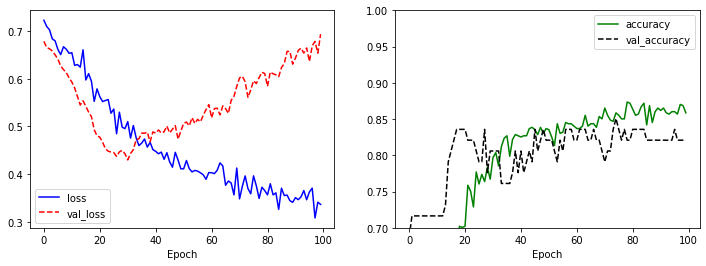

In [379]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

In [380]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.5623 - accuracy: 0.7937


[0.5623493790626526, 0.7937219738960266]

In [231]:
test_pred = model.predict(test)

In [232]:
test_pred_argmax = np.argmax(test_pred, axis=1)

In [233]:
test_pred_argmax

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [234]:
sub = submit['PassengerId']

In [235]:
sub = pd.concat([sub, pd.DataFrame(test_pred_argmax, columns=['Survived'])], axis=1)

In [236]:
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [127]:
sub.to_csv("/content/drive/MyDrive/submission_0228.csv", index=False)